In [1]:
%matplotlib inline


# Gaussian processes on discrete data structures


This example illustrates the use of Gaussian processes for regression and
classification tasks on data that are not in fixed-length feature vector form.
This is achieved through the use of kernel functions that operates directly
on discrete structures such as variable-length sequences, trees, and graphs.

Specifically, here the input variables are some gene sequences stored as
variable-length strings consisting of letters 'A', 'T', 'C', and 'G',
while the output variables are floating point numbers and True/False labels
in the regression and classification tasks, respectively.

A kernel between the gene sequences is defined using R-convolution [1]_ by
integrating a binary letter-wise kernel over all pairs of letters among a pair
of strings.

This example will generate three figures.

In the first figure, we visualize the value of the kernel, i.e. the similarity
of the sequences, using a colormap. Brighter color here indicates higher
similarity.

In the second figure, we show some regression result on a dataset of 6
sequences. Here we use the 1st, 2nd, 4th, and 5th sequences as the training set
to make predictions on the 3rd and 6th sequences.

In the third figure, we demonstrate a classification model by training on 6
sequences and make predictions on another 5 sequences. The ground truth here is
simply  whether there is at least one 'A' in the sequence. Here the model makes
four correct classifications and fails on one.

.. [1] Haussler, D. (1999). Convolution kernels on discrete structures
       (Vol. 646). Technical report, Department of Computer Science, University
       of California at Santa Cruz.



Classification



KeyboardInterrupt: 

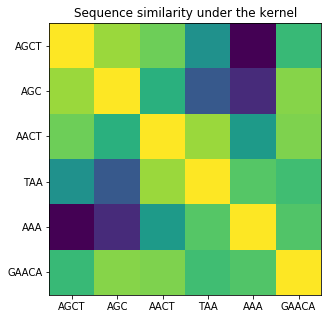

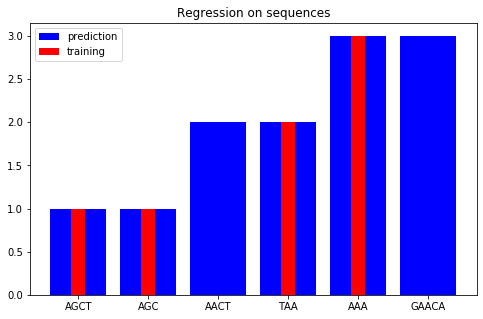

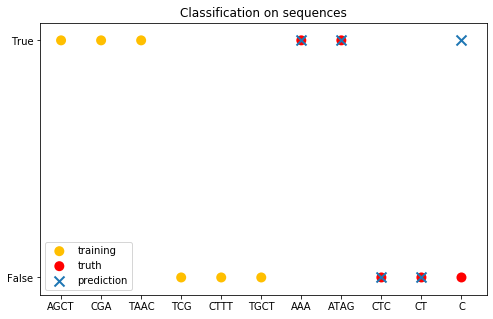

In [3]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter
from sklearn.gaussian_process.kernels import GenericKernelMixin
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.base import clone


class SequenceKernel(GenericKernelMixin, Kernel):
    '''
    A minimal (but valid) convolutional kernel for sequences of variable
    lengths.'''
    def __init__(self,
                 baseline_similarity=0.5,
                 baseline_similarity_bounds=(1e-5, 1)):
        self.baseline_similarity = baseline_similarity
        self.baseline_similarity_bounds = baseline_similarity_bounds

    @property
    def hyperparameter_baseline_similarity(self):
        return Hyperparameter("baseline_similarity",
                              "numeric",
                              self.baseline_similarity_bounds)

    def _f(self, s1, s2):
        '''
        kernel value between a pair of sequences
        '''
        return sum([1.0 if c1 == c2 else self.baseline_similarity
                   for c1 in s1
                   for c2 in s2])

    def _g(self, s1, s2):
        '''
        kernel derivative between a pair of sequences
        '''
        return sum([0.0 if c1 == c2 else 1.0
                    for c1 in s1
                    for c2 in s2])

    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            Y = X

        if eval_gradient:
            return (np.array([[self._f(x, y) for y in Y] for x in X]),
                    np.array([[[self._g(x, y)] for y in Y] for x in X]))
        else:
            return np.array([[self._f(x, y) for y in Y] for x in X])

    def diag(self, X):
        return np.array([self._f(x, x) for x in X])

    def is_stationary(self):
        return False

    def clone_with_theta(self, theta):
        cloned = clone(self)
        cloned.theta = theta
        return cloned


kernel = SequenceKernel()

'''
Sequence similarity matrix under the kernel
===========================================
'''

X = np.array(['AGCT', 'AGC', 'AACT', 'TAA', 'AAA', 'GAACA'])

K = kernel(X)
D = kernel.diag(X)

plt.figure(figsize=(8, 5))
plt.imshow(np.diag(D**-0.5).dot(K).dot(np.diag(D**-0.5)))
plt.xticks(np.arange(len(X)), X)
plt.yticks(np.arange(len(X)), X)
plt.title('Sequence similarity under the kernel')

'''
Regression
==========
'''

X = np.array(['AGCT', 'AGC', 'AACT', 'TAA', 'AAA', 'GAACA'])
Y = np.array([1.0, 1.0, 2.0, 2.0, 3.0, 3.0])

training_idx = [0, 1, 3, 4]
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X[training_idx], Y[training_idx])

plt.figure(figsize=(8, 5))
plt.bar(np.arange(len(X)), gp.predict(X), color='b', label='prediction')
plt.bar(training_idx, Y[training_idx], width=0.2, color='r',
        alpha=1, label='training')
plt.xticks(np.arange(len(X)), X)
plt.title('Regression on sequences')
plt.legend()

'''
Classification
==============
'''

X_train = np.array(['AGCT', 'CGA', 'TAAC', 'TCG', 'CTTT', 'TGCT'])
# whether there are 'A's in the sequence
Y_train = np.array([True, True, True, False, False, False])

gp = GaussianProcessClassifier(kernel)
gp.fit(X_train, Y_train)

X_test = ['AAA', 'ATAG', 'CTC', 'CT', 'C']
Y_test = [True, True, False, False, False]

plt.figure(figsize=(8, 5))
plt.scatter(np.arange(len(X_train)), [1.0 if c else -1.0 for c in Y_train],
            s=100, marker='o', edgecolor='none', facecolor=(1, 0.75, 0),
            label='training')
plt.scatter(len(X_train) + np.arange(len(X_test)),
            [1.0 if c else -1.0 for c in Y_test],
            s=100, marker='o', edgecolor='none', facecolor='r', label='truth')
plt.scatter(len(X_train) + np.arange(len(X_test)),
            [1.0 if c else -1.0 for c in gp.predict(X_test)],
            s=100, marker='x', edgecolor=(0, 1.0, 0.3), linewidth=2,
            label='prediction')
plt.xticks(np.arange(len(X_train) + len(X_test)),
           np.concatenate((X_train, X_test)))
plt.yticks([-1, 1], [False, True])
plt.title('Classification on sequences')
plt.legend()

plt.show()